In [1]:
%reload_ext autoreload
%autoreload 2


import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d

from collections import Counter



    
import allsim.infer as infer
from data.data_module import UNOSDataModule, UKRegDataModule

/tmp/ipykernel_297611/723481901.py:16: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
data = 'UKReg'
data_dir = f'../data/{data}'

if data == 'UNOS':
    dm = UNOSDataModule(data_dir, batch_size=256)
else:
    dm = UKRegDataModule(data_dir, batch_size=256)

dm.prepare_data()
dm.setup(stage='fit')

DATA = pd.concat([dm._test_processed.copy(deep=True), dm._train_processed.copy(deep=True)])
DATA_true = DATA.copy(deep=True)
DATA_true[dm.real_cols] = dm.scaler.inverse_transform(
    DATA_true[dm.real_cols])
DATA_true['retrieval_date_time'] = pd.to_datetime(
    DATA_true.retrieval_date, unit='s')

patients = DATA_true[dm.x_cols].copy(deep=True)
organs = DATA_true[
    [*np.delete(dm.o_cols, np.where(dm.o_cols == 'retrieval_date')), 'retrieval_date_time']
].copy(deep=True)

X = patients
O = organs
Y = dm._train_processed.Y


O_indices_in_real_cols = np.where(np.in1d(dm.real_cols, O.columns.values))[0]
mean_real_cols_O = dm.scaler.mean_[O_indices_in_real_cols]
scale_real_cols_O = dm.scaler.scale_[O_indices_in_real_cols]
real_cols_indices_in_O = np.where(np.in1d(O.columns.values, dm.real_cols))[0]


/home/rob/miniconda3/envs/allsim/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
bins = [30, 45, 60]

def condition_function(age):
    i = np.where(np.in1d(dm.real_cols, 'DAGE'))[0]
    age=age
    return np.digitize(age, bins=bins).item()


condition = infer.Condition(
    labels=['DAGE'],
    function=condition_function,
    options=len(bins) + 1
)

kde = infer.KDEDensity(condition=condition, K=len(bins) + 1, drop=['retrieval_date_time'])


kde.fit(O, [['DCOD_0', 'DCOD_10', 'DCOD_11', 'DCOD_12',
       'DCOD_13', 'DCOD_19', 'DCOD_20', 'DCOD_21', 'DCOD_22', 'DCOD_23',
       'DCOD_24', 'DCOD_29', 'DCOD_30', 'DCOD_31', 'DCOD_39', 'DCOD_40',
       'DCOD_41', 'DCOD_42', 'DCOD_43', 'DCOD_44', 'DCOD_45', 'DCOD_49',
       'DCOD_50', 'DCOD_51', 'DCOD_52', 'DCOD_53', 'DCOD_54', 'DCOD_59',
       'DCOD_60', 'DCOD_70', 'DCOD_71', 'DCOD_72', 'DCOD_81', 'DCOD_82',
       'DCOD_85', 'DCOD_88', 'DCOD_90', 'DCOD_98', 'DCOD_99']])

In [4]:
years = [2017, 2018, 2019]
system = dict()

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


O_ = O[pd.DatetimeIndex(O.retrieval_date_time).year.isin(years)]

data = dict()

for c in kde.D.condition.unique():
    xy = np.empty((0, 2))
    conditioned_group = kde.D[kde.D.condition == c].copy(deep=True)
    
    for i, year in enumerate(years):
        rates = dict(Counter([
            date.month for date in conditioned_group[
                pd.DatetimeIndex(
                    conditioned_group.retrieval_date_time).year == year
            ].retrieval_date_time
        ]))
        xy = np.append(xy, np.array(
            [[k + i * 12, v] for k, v in rates.items()]
        ), axis=0)
        
        O_.loc[
            pd.DatetimeIndex(O_.retrieval_date_time).year == year, 't'
        ] = (pd.DatetimeIndex(O_.loc[
            pd.DatetimeIndex(O_.retrieval_date_time).year == year, 'retrieval_date_time'
        ]).month + (i  *12)) * 30 - 29
    

    xy = xy[np.argsort(xy[:, 0])]
    xy[:, 0] *= 30
    xy[:, 0] -= 29
    
    data[c] = xy
    
    
    

/tmp/ipykernel_297611/2864182022.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  O_.loc[


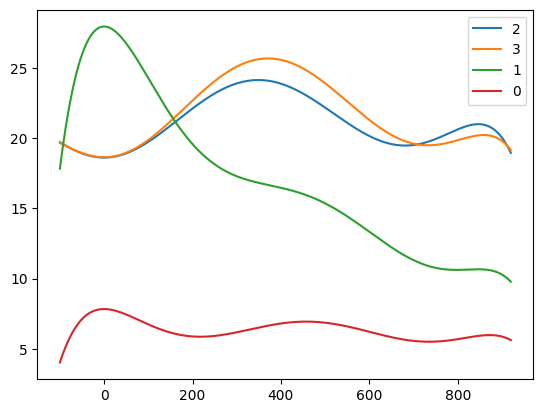

In [5]:
system = dict()

class function:
    def __init__(self, model):
        self.model = model
    
    def fit(self, x, y):
        self.model.fit(x, y)
    
    def __call__(self, x):
        x = np.array(x).reshape(-1, 1)
        return max(self.model.predict(x).item(), 0)


for c, d in data.items():
    func = function(Pipeline([
        ('poly', PolynomialFeatures(degree=6)),
        ('linear', LinearRegression(fit_intercept=True))]))
    
    func.fit(d[:,0].reshape(-1, 1), d[:,1])
    
    system[c] = infer.PoissonProcess(update_lam=func)


    plt.plot(
        range(-100, 921), 
        [system[c].update_lam(i) for i in range(-100, 921)],
        label=c
    )
plt.legend()

In [6]:
xy = np.empty((0, 2))
for i, year in enumerate(years):
    rates = dict(Counter([
                date.month for date in O_[
                    pd.DatetimeIndex(
                        O_.retrieval_date_time).year == year
                ].retrieval_date_time
            ]))
    xy = np.append(xy, np.array([[k + i * 12, v] for k, v in rates.items()]), axis=0)
    xy = xy[np.argsort(xy[:, 0])]
    xy[:, 0] *= 30
    xy[:, 0] -= 29



m = LinearRegression()
m = m.fit(xy[:-2, 0].reshape(-1, 1), xy[:-2, 1])

alpha = lambda x: max(m.predict(np.array(x).reshape(-1, 1)).item(), 0)

poisson_system = infer.PoissonSystem(
    density=kde, 
    system=system, 
    alpha=alpha, 
    normalize=True)

In [7]:
T = range(1, len(years)*30*12 - 1)

stream = pd.DataFrame(columns=[*O.columns.values, 't'])

for t in T:
    O_sample = poisson_system(t)
    #O_sample.loc[:, dm.real_cols[O_indices_in_real_cols]] = O_sample.loc[:, dm.real_cols[O_indices_in_real_cols]] * scale_real_cols_O + mean_real_cols_O
    O_sample.loc[:, 't'] = np.repeat([t], len(O_sample))
    stream = stream.append(O_sample)

    


/tmp/ipykernel_297611/2855249360.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stream = stream.append(O_sample)
/tmp/ipykernel_297611/2855249360.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stream = stream.append(O_sample)
/tmp/ipykernel_297611/2855249360.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stream = stream.append(O_sample)
/tmp/ipykernel_297611/2855249360.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stream = stream.append(O_sample)
/tmp/ipykernel_297611/2855249360.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Select DMBI or DAGE for figure 5 plots

/tmp/ipykernel_297611/262068068.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averages = stream.groupby('t_').agg('mean')
/tmp/ipykernel_297611/262068068.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_real = O_.groupby('t').agg('mean')


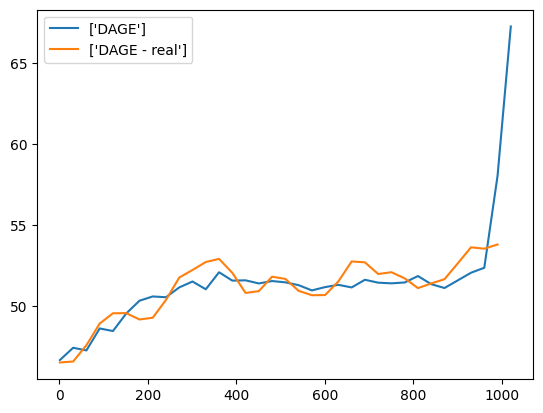

In [8]:
# COLS = ['DBMI']
COLS = ['DAGE']
stream.loc[:, 'condition'] = stream.apply(condition, axis=1)

stream.loc[:, 't_'] = (stream.t - stream.t % 30) + 1
averages = stream.groupby('t_').agg('mean')

plt.plot(
    averages.index.to_numpy(), 
    #gaussian_filter1d(averages[COLS].to_numpy(), sigma=1, axis=0), 
    averages[COLS].to_numpy()+.5,
    label=COLS
)

average_real = O_.groupby('t').agg('mean')

plt.plot(
    averages.index.to_numpy()[:-1], 
    gaussian_filter1d(
        average_real[COLS].to_numpy(), sigma=1, axis=0)[:-2], 
    #average_real[COL].to_numpy(),
    label=['DAGE - real']
)


plt.legend()

In [9]:
COL='DBMI'

print(f'SIMULATED {COL}\n')
print(
    *list(zip(
        averages.index.to_numpy()[:-1],
        averages[COLS].to_numpy().flatten()[1:]+.5,
        #gaussian_filter1d(averages[COL].to_numpy().flatten(), sigma=1, axis=0)
    )),
    sep=' '
)
print('\n\n')

print(f'REAL {COL}\n')
print(
    *list(zip(
        averages.index.to_numpy()[:-1], 
        gaussian_filter1d(
            average_real[COL].to_numpy(), sigma=1, axis=0)[:-2])),
    sep=' '
)

SIMULATED DBMI

(1, 47.401716819862706) (31, 47.23798839060429) (61, 48.596333453018296) (91, 48.43445138008979) (121, 49.519994271503855) (151, 50.31032265038207) (181, 50.57455626375895) (211, 50.525690697051495) (241, 51.1327801211682) (271, 51.49783069692744) (301, 51.01804466734757) (331, 52.07000681919517) (361, 51.55385918974791) (391, 51.57128357911402) (421, 51.37941240993168) (451, 51.527359497879424) (481, 51.44656074508377) (511, 51.273242887383304) (541, 50.94818829995213) (571, 51.15295329873573) (601, 51.294026426312165) (631, 51.13072825762164) (661, 51.60649685952759) (691, 51.42658060586328) (721, 51.38503734534984) (751, 51.43829022197228) (781, 51.83612026959996) (811, 51.33241748213756) (841, 51.09689255512351) (871, 51.567253019133226) (901, 52.04079505928056) (931, 52.34819661177741) (961, 58.02532588740022) (991, 67.26582256471674)



REAL DBMI

(1, 25.184812098462118) (31, 25.4209577347195) (61, 25.993782858993676) (91, 26.345690374903086) (121, 26.086090361486

%%%%%%%-- 0 --%%%%%%%
(1, 4.016516011679881) (11, 4.902137399583841) (21, 5.638617951822789) (31, 6.241591805740612) (41, 6.725637219916361) (51, 7.1043194011240995) (61, 7.390232525536689) (71, 7.59504095417351) (81, 7.729519642592119) (91, 7.803593744823834) (101, 7.82637741155326) (111, 7.806211782541741) (121, 7.750702173294753) (131, 7.666754455973227) (141, 7.560610634548809) (151, 7.437883614203045) (161, 7.303591164970515) (171, 7.162189079625889) (181, 7.017603525814915) (191, 6.873262592429357) (201, 6.732127030225845) (211, 6.596720186688681) (221, 6.469157135136555) (231, 6.3511729980732206) (241, 6.244150464782084) (251, 6.149146503164735) (261, 6.066918265823412) (271, 5.997948190387405) (281, 5.94246829408338) (291, 5.900483662549648) (301, 5.8717951328943725) (311, 5.8560211709976855) (321, 5.8526189430577755) (331, 5.860904581380874) (341, 5.880072644415199) (351, 5.909214771028824) (361, 5.947337529031476) (371, 5.993379457940275) (381, 6.046227305989407) (391, 6.1047

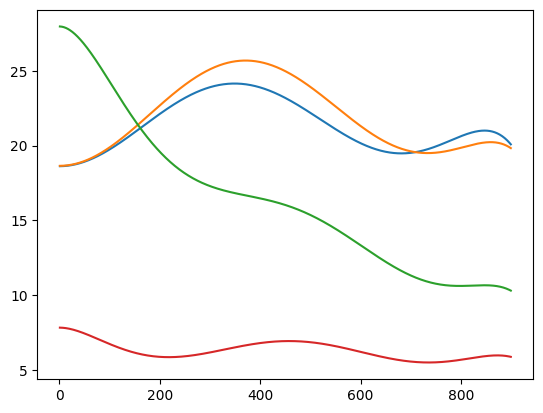

In [10]:
for c, _ in data.items():
    plt.plot(
        range(1, 900), 
        [system[c].update_lam(i) for i in range(1, 900)],
        label=c
    )
    
for c in range(len(bins)+1):
    
    print(f"%%%%%%%-- {c} --%%%%%%%")
    print(*list(zip(
        np.arange(1, 1021, 10),
        [system[c].update_lam(i) for i in np.arange(-100, 921, 10)]
    )), sep=" ")


In [11]:
np.arange(1, 900, 10)

array([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
       131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
       261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381,
       391, 401, 411, 421, 431, 441, 451, 461, 471, 481, 491, 501, 511,
       521, 531, 541, 551, 561, 571, 581, 591, 601, 611, 621, 631, 641,
       651, 661, 671, 681, 691, 701, 711, 721, 731, 741, 751, 761, 771,
       781, 791, 801, 811, 821, 831, 841, 851, 861, 871, 881, 891])

In [12]:
bins

[30, 45, 60]